In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow. keras.utils import plot_model

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adas754","key":"6f1fc5ba50f3e264c2c139898e2e7c37"}'}

In [7]:
!mkdir -p ~/.Kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d msambare/fer2013

 56% 34.0M/60.3M [00:00<00:00, 178MB/s]
100% 60.3M/60.3M [00:00<00:00, 202MB/s]


In [9]:
os.system('apt-get install p7zip')

0

In [10]:
from zipfile import ZipFile
file_name="fer2013.zip"
with ZipFile(file_name,'r')as zip:
  zip.extractall()
  print('Done')

Done


In [11]:
train_dir = "content/train" #passing the path with training images
test_dir = "content/test"   #passing the path with testing images

In [12]:
import numpy as np
from google.colab.patches import cv2_imshow
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

mode = "display"

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


def emotion_recog(frame):
    model.load_weights('model.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

    # frame = cv2.imread("image1.jpg")
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 255), 3)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # cv2_imshow(frame)
    return frame


In [13]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [14]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

In [16]:
emotion_model.compile(loss='kullback_leibler_divergence',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
448/448 [==============================] - 22s 25ms/step - loss: 1.8032 - accuracy: 0.2588 - val_loss: 1.7265 - val_accuracy: 0.3252
Epoch 2/50
448/448 [==============================] - 10s 23ms/step - loss: 1.6396 - accuracy: 0.3596 - val_loss: 1.5631 - val_accuracy: 0.4083
Epoch 3/50
448/448 [==============================] - 11s 23ms/step - loss: 1.5506 - accuracy: 0.4010 - val_loss: 1.4990 - val_accuracy: 0.4212
Epoch 4/50
448/448 [==============================] - 10s 23ms/step - loss: 1.4834 - accuracy: 0.4296 - val_loss: 1.4321 - val_accuracy: 0.4559
Epoch 5/50
448/448 [==============================] - 10s 23ms/step - loss: 1.4218 - accuracy: 0.4589 - val_loss: 1.3723 - val_accuracy: 0.4798
Epoch 6/50
448/448 [==============================] - 10s 23ms/step - loss: 1.3719 - accuracy: 0.4753 - val_loss: 1.3315 - val_accuracy: 0.4960
Epoch 7/50
448/448 [==============================] - 10s 23ms/step - loss: 1.3212 - accuracy: 0.4986 - val_loss: 1.2951 - val_accuracy:

In [17]:
emotion_model.save('model.h5')

In [18]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [19]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
def emotion_analysis(emotions):
    
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

OpenCV(4.1.2) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'



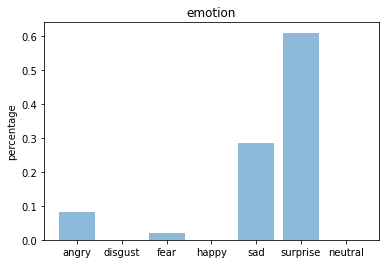

[[8.2628921e-02 7.9629230e-05 2.1058558e-02 9.6820033e-05 2.8572536e-01
  6.0986006e-01 5.5071909e-04]]
<class 'numpy.ndarray'>
0.60986006
0.60986006
5
('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
surprise
emotion: surprise


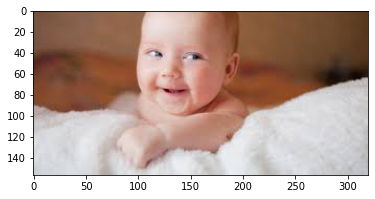

In [21]:
import cv2
            
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('/content/child.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)

   


if __name__ == '__main__':
    facecrop('/content/child.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/child.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

#x = np.array(x, 'float32')
#x = x.reshape([48, 48]);

print(custom)
print(type(custom))
print(np.amax(custom))
m=np.amax(custom)
cus=custom.flatten()
cust=cus.tolist()
print(m)
index=cust.index(m)
#print(np.where(m==np.max(custom)))
print(index)
print(objects)

'''
m=custom[0]
for i in len(objects):
  if custom[i]>custom[i+1]:
    m=custom[i]
    break;
'''
print(objects[index])
anw=objects[index]
print("emotion:",anw)
plt.imshow(true_image)
plt.show()

In [22]:
import urllib.request
import re

if anw=="angry":
  search_keyword="happy"
  html = urllib.request.urlopen("https://www.youtube.com/watch?v=1ZYbU82GVz4&t=596s" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="surprise":
  search_keyword="motivation"
  html = urllib.request.urlopen("https://www.youtube.com/watch?v=6qWpSewDy5Y" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="fear":
  search_keyword="brave"
  html = urllib.request.urlopen("https://youtu.be/7D16blZDRr8" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="disgust":
  search_keyword="happy"
  html = urllib.request.urlopen("https://youtu.be/7D16blZDRr8" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="happy":
  search_keyword="happy"
  html = urllib.request.urlopen("https://youtu.be/nRtRlmoyfyw" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="sad":
  search_keyword="happy"
  html = urllib.request.urlopen("https://youtu.be/RE29EUeJAb0" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
elif anw=="neutral":
  search_keyword="happy"
  html = urllib.request.urlopen("https://youtu.be/7D16blZDRr8" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])
else:
  search_keyword="happy"
  html = urllib.request.urlopen("https://youtu.be/7D16blZDRr8" + search_keyword)
  video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
  print("https://www.youtube.com/watch?v=" + video_ids[0])









https://www.youtube.com/watch?v=6qWpSewDy5Y
